In [ ]:
import pandas as pd
import numpy as np

# For reproducibility
np.random.seed(42)
n_samples = 10000

def random_salary(education, experience, job_level):
    base = 25000
    return base + education*2000 + experience*1500 + job_level*5000 + np.random.normal(0, 2000)

data = pd.DataFrame({
    'age': np.random.randint(20, 60, size=n_samples),
    'education_level': np.random.randint(1, 6, size=n_samples),  # 1:HighSchool, 5:PhD
    'years_experience': np.random.randint(0, 40, size=n_samples),
    'job_level': np.random.randint(1, 6, size=n_samples),  # 1-Junior to 5-Executive
    'gender': np.random.choice(['Male', 'Female', 'Other'], size=n_samples),
    'industry': np.random.choice(['IT', 'Finance', 'Healthcare', 'Manufacturing', 'Education'], size=n_samples),
    'city': np.random.choice(['Bangalore', 'Mumbai', 'Hyderabad', 'Delhi', 'Chennai'], size=n_samples),
    'hours_per_week': np.random.randint(30, 60, size=n_samples),
    'remote_ratio': np.random.choice([0, 50, 100], size=n_samples),
})

# Add target column: salary
data['salary'] = data.apply(lambda row: random_salary(row['education_level'], row['years_experience'], row['job_level']), axis=1)

data.head()


,age,education_level,years_experience,job_level,gender,industry,city,hours_per_week,remote_ratio,salary
0,58,1,17,1,Other,IT,Chennai,59,0,57828.952054
1,48,2,31,4,Other,Healthcare,Bangalore,49,50,92735.982371
2,34,2,30,5,Female,Manufacturing,Hyderabad,39,100,94909.882205
3,27,3,10,3,Male,Manufacturing,Hyderabad,49,100,59001.972439
4,40,5,25,2,Female,Manufacturing,Chennai,37,50,84189.652377


In [ ]:
data.to_csv("salary_data.csv", index=False)


In [ ]:
# Add some missing values
for col in ['gender', 'industry', 'city']:
    data.loc[data.sample(frac=0.01).index, col] = np.nan

# Introduce outliers
data.loc[data.sample(frac=0.005).index, 'salary'] *= 3

# Drop duplicates if any
data.drop_duplicates(inplace=True)

# Check for missing values
data.isna().sum()


,0
age,0
education_level,0
years_experience,0
job_level,0
gender,100
industry,100
city,100
hours_per_week,0
remote_ratio,0
salary,0


In [ ]:
# Fill missing categorical values
data['gender'].fillna('Other', inplace=True)
data['industry'].fillna('Unknown', inplace=True)
data['city'].fillna('Unknown', inplace=True)

# Encode categoricals
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
for col in ['gender', 'industry', 'city']:
    data[col] = encoder.fit_transform(data[col])


/tmp/ipython-input-7-3130932227.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['gender'].fillna('Other', inplace=True)
/tmp/ipython-input-7-3130932227.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try us

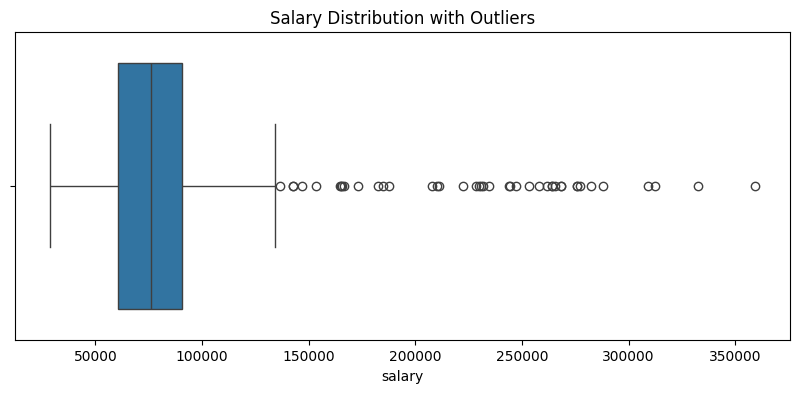

In [ ]:
# Optional: Visualize
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
sns.boxplot(x=data['salary'])
plt.title("Salary Distribution with Outliers")
plt.show()

# Remove extreme salaries above 3 SD
from scipy import stats
data = data[(np.abs(stats.zscore(data['salary'])) < 3)]


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler

# Split
X = data.drop(columns=['salary'])
y = data['salary']

# Scale features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
xtrain, xtest, ytrain, ytest = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(xtrain, ytrain)
pred = model.predict(xtest)

# Metrics
print("MAE:", mean_absolute_error(ytest, pred))
print("R2 Score:", r2_score(ytest, pred))


MAE: 2058.089691185586
R2 Score: 0.9574402679832932


In [ ]:
import joblib

joblib.dump(model, 'salary_model.pkl')
joblib.dump(scaler, 'scaler.pkl')


['scaler.pkl']

In [ ]:
import streamlit as st
import numpy as np
import joblib

model = joblib.load('salary_model.pkl')
scaler = joblib.load('scaler.pkl')

st.title("💰 Employee Salary Estimator")

age = st.slider("Age", 20, 60, 30)
education = st.slider("Education Level (1-High School, 5-PhD)", 1, 5, 3)
experience = st.slider("Years of Experience", 0, 40, 5)
job_level = st.slider("Job Level (1-Junior to 5-Exec)", 1, 5, 2)
gender = st.selectbox("Gender", ['Male', 'Female', 'Other'])
industry = st.selectbox("Industry", ['IT', 'Finance', 'Healthcare', 'Manufacturing', 'Education', 'Unknown'])
city = st.selectbox("City", ['Bangalore', 'Mumbai', 'Hyderabad', 'Delhi', 'Chennai', 'Unknown'])
hours = st.slider("Hours per week", 30, 60, 40)
remote = st.selectbox("Remote Work (%)", [0, 50, 100])

# Manual encodings (must match training)
gender_map = {'Male': 1, 'Female': 0, 'Other': 2}
industry_map = {'IT': 2, 'Finance': 1, 'Healthcare': 3, 'Manufacturing': 4, 'Education': 0, 'Unknown': 5}
city_map = {'Bangalore': 0, 'Mumbai': 2, 'Hyderabad': 1, 'Delhi': 3, 'Chennai': 4, 'Unknown': 5}

features = np.array([[
    age,
    education,
    experience,
    job_level,
    gender_map[gender],
    industry_map[industry],
    city_map[city],
    hours,
    remote
]])

features_scaled = scaler.transform(features)
salary = model.predict(features_scaled)[0]

st.success(f"💸 Predicted Salary: ₹{int(salary):,}")


ModuleNotFoundError: No module named 'streamlit'

In [ ]:
app_code = '''
import streamlit as st
import numpy as np
import joblib

model = joblib.load('salary_model.pkl')
scaler = joblib.load('scaler.pkl')

st.title("💰 Employee Salary Estimator")

age = st.slider("Age", 20, 60, 30)
education = st.slider("Education Level (1-High School, 5-PhD)", 1, 5, 3)
experience = st.slider("Years of Experience", 0, 40, 5)
job_level = st.slider("Job Level (1-Junior to 5-Exec)", 1, 5, 2)
gender = st.selectbox("Gender", ['Male', 'Female', 'Other'])
industry = st.selectbox("Industry", ['IT', 'Finance', 'Healthcare', 'Manufacturing', 'Education', 'Unknown'])
city = st.selectbox("City", ['Bangalore', 'Mumbai', 'Hyderabad', 'Delhi', 'Chennai', 'Unknown'])
hours = st.slider("Hours per week", 30, 60, 40)
remote = st.selectbox("Remote Work (%)", [0, 50, 100])

gender_map = {'Male': 1, 'Female': 0, 'Other': 2}
industry_map = {'IT': 2, 'Finance': 1, 'Healthcare': 3, 'Manufacturing': 4, 'Education': 0, 'Unknown': 5}
city_map = {'Bangalore': 0, 'Mumbai': 2, 'Hyderabad': 1, 'Delhi': 3, 'Chennai': 4, 'Unknown': 5}

features = np.array([[
    age,
    education,
    experience,
    job_level,
    gender_map[gender],
    industry_map[industry],
    city_map[city],
    hours,
    remote
]])

features_scaled = scaler.transform(features)
salary = model.predict(features_scaled)[0]

st.success(f"💸 Predicted Salary: ₹{int(salary):,}")
'''

# Save to file
with open('app.py', 'w') as f:
    f.write(app_code)


In [ ]:
from google.colab import files
files.download('app.py')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files
files.download('salary_model.pkl')
files.download('scaler.pkl')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [22]:
from google.colab import files
files.download('salary_data.csv')
files.download('final_salary_data.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pandas as pd

data = pd.read_csv("salary_data.csv")
data.head()


,age,education_level,years_experience,job_level,gender,industry,city,hours_per_week,remote_ratio,salary
0,58,1,17,1,2,3,1,59,0,57828.952054
1,48,2,31,4,2,2,0,49,50,92735.982371
2,34,2,30,5,0,4,3,39,100,94909.882205
3,27,3,10,3,1,4,3,49,100,59001.972439
4,40,5,25,2,0,4,1,37,50,84189.652377


In [ ]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split

# Label encode categorical columns
le = LabelEncoder()
for col in ['gender', 'industry', 'city']:
    data[col] = le.fit_transform(data[col])

# Features & target
X = data.drop("salary", axis=1)
y = data["salary"]

# Scale features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

model = RandomForestRegressor(n_estimators=200, random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluation
print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred))
print("R2 Score:", r2_score(y_test, y_pred))


Mean Absolute Error: 2053.389965434942
R2 Score: 0.9582100780656011


In [ ]:
import joblib

# Save model and scaler
joblib.dump(model, 'salary_modell.pkl')
joblib.dump(scaler, 'scalerr.pkl')


['scalerr.pkl']

In [ ]:
from google.colab import files

files.download('salary_modell.pkl')
files.download('scalerr.pkl')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [20]:
data.to_csv("final_salary_data.csv", index=False)


In [25]:
import joblib

# Save with compression
joblib.dump(model, 'salary_modell.pkl', compress=3)


['salary_modell.pkl']

In [24]:
import os
os.remove('salary_modell.pkl')


In [26]:
from google.colab import files
files.download('salary_modell.pkl')



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [29]:
joblib.dump(model, 'salary_modell.pkl', compress=9)


['salary_modell.pkl']

In [30]:
from google.colab import files
files.download('salary_modell.pkl')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>